# Imports
DISTIL-BERT with sentiments analysis: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
# Install the bertopic library if needed
!pip install bertopic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039287 sha256=7edd59333d47feb0cf28e044a3c2a84a05bf51f5435c926ef467d4321edd36c9
  Stored in dire

In [ ]:
!pip install jsonlines

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.0.0/en_core_web_md-3.0.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 10.9 MB/s eta 0:00:00
  Created wheel for en-core-web-md: filename=en_core_web_md-3.0.0-py3-none-any.whl size=47053310 sha256=a807b8d4ce46859b1faf261ea569295bf0071eca896ed24c1da7a8e9837cf7a1
  Stored in directory: /root/.cache/pip/wheels/75/47/b6/1138aff8b49cd20e39c338e51d2ae35d79fb86e77c7ad97c60
Successfully built en-core-web-md
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Unin

In [ ]:
# Imports
import jsonlines
import torch
import re

import spacy
import en_core_web_md

from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [ ]:
torch.cuda.set_device(0)

# type of tensor in GPU
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data loading and cleaning

In [ ]:
#Load the data

# path to the data (angela)
docs_path ='/content/drive/MyDrive/AIR/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/docs.csv'
queries_path='/content/drive/MyDrive/AIR/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/queries.csv'
qrels = '/content/drive/MyDrive/AIR/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/qrels.csv'

docs_df = pd.read_csv(docs_path)
queries_df = pd.read_csv(queries_path)
qrels_df = pd.read_csv(qrels)

In [ ]:
docs_df

id_document                 _id  \
0                 0  638501434560876544   
1                 1  638501569130950656   
2                 2  638501432094670848   
3                 3  638501569089040384   
4                 4  638501569319702528   
...             ...                 ...   
261897       261897  640219441700147202   
261898       261898  649061773820174340   
261899       261899  643673680829149184   
261900       261900  645380013034835968   
261901       261901  641186908463230976   

                                                     docs  
0       September Starts With A Sizzle: We’re putting ...  
1             West Nile virus found across DeKalb County:  
2       European efforts to stem migrant tide sow chao...  
3       Heads up for official China PMIs in one hour. ...  
4       San Diego is top travel destination for Labor ...  
...                                                   ...  
261897  #BREAKING: Police say missing 11-year-old has ...  
261898  Sen. Bong Revilla admits that he wants to run ...  
261899  @BBCGaryR @BBCNews I am a migrant, there is no...  
261900  @TyTheWeatherGuy @CStewartWPTV a win is a win ...  
261901  Ease of doing business, cost of labour and cap...  

[261902 rows x 3 columns]

In [ ]:
queries_df

id_query                         query
0             0             when is september
1             1  when is the end of september
2             2     when does september start
3             3      what county is dekalb in
4             4     hungarian border crossing
...         ...                           ...
23596     23596     is caitlyn jenner charged
23597     23597   when did caitlyn jenner die
23598     23598    was caitlyn jenner charged
23599     23599         who is maria mitousis
23600     23600               who is mitousis

[23601 rows x 2 columns]

In [ ]:
qrels_df

Key                                             Values
0          0  [0, 357, 1216, 1373, 1430, 1448, 1460, 1488, 2...
1          1         [0, 83973, 132031, 210321, 239534, 255446]
2          2             [0, 5326, 7397, 57994, 103641, 181347]
3          3  [1, 106, 217, 629, 1325, 6634, 9134, 10795, 17...
4          4                 [2, 46184, 129431, 131155, 139634]
...      ...                                                ...
23596  23596  [260627, 260631, 260691, 260743, 260817, 26099...
23597  23597           [260638, 260655, 261233, 261590, 261834]
23598  23598           [260691, 261258, 261365, 261377, 261697]
23599  23599  [260781, 260851, 260859, 260873, 260876, 26092...
23600  23600  [260881, 260987, 261010, 261064, 261103, 26115...

[23601 rows x 2 columns]

In [ ]:
# reduction of the dataset because of computational costs
print(f'---The original length of docs in the dataset is {len(docs_df)}')
new_end = 40000
cut_docs_df = docs_df.iloc[:new_end]

print(f'---The length of the reduced docs in the dataset is {len(cut_docs_df)}')

matching_keys = []
range_set = set(range(new_end + 1))

qrels_df['Key'] = qrels_df['Key'].astype(int)
queries_df['id_query'] = queries_df['id_query'].astype(int)

for index, row in qrels_df.iterrows():
    values_set = set(int(num.strip()) for num in row['Values'].split(',') if num.strip().isdigit())
    if range_set.intersection(values_set):
        matching_keys.append(row['Key'])
matching_keys_set = set(matching_keys)
cut_queries_df = queries_df[queries_df['id_query'].isin(matching_keys_set)]

print(f'Docs length is {len(cut_docs_df)}')
print(f'Queries length is {len(cut_queries_df)}')


---The original length of docs in the dataset is 261902
---The length of the reduced docs in the dataset is 40000
Docs length is 40000
Queries length is 7989


In [ ]:
cut_docs_df

id_document                 _id  \
0                0  638501434560876544   
1                1  638501569130950656   
2                2  638501432094670848   
3                3  638501569089040384   
4                4  638501569319702528   
...            ...                 ...   
39995        39995  639843677116874752   
39996        39996  639843665221779456   
39997        39997  639843671806996480   
39998        39998  639843776052105216   
39999        39999  639843888723836928   

                                                    docs  
0      September Starts With A Sizzle: We’re putting ...  
1            West Nile virus found across DeKalb County:  
2      European efforts to stem migrant tide sow chao...  
3      Heads up for official China PMIs in one hour. ...  
4      San Diego is top travel destination for Labor ...  
...                                                  ...  
39995  RT @wattsupbrent: Don't go to tonight's games ...  
39996  #TheHotSeat  | A lot depends on the personal v...  
39997         Be patient.. you will soon be at #epathome  
39998  DTN Iraq: Britain to provide extra Â£100 mln i...  
39999  WLBT News at Noon starts in 5 minutes… Click  ...  

[40000 rows x 3 columns]

In [ ]:
cut_queries_df

id_query                                query
0             0                    when is september
2             2            when does september start
3             3             what county is dekalb in
5             5                            china pmi
6             6                   where is san diego
...         ...                                  ...
13045     13045      why do drivers kill pedestrians
13067     13067  how many people died in tadjikistan
13069     13069                  who is maria gaidar
13078     13078                    who is ben cardin
13090     13090                  who is drew goforth

[7989 rows x 2 columns]

In [ ]:
# Function to clean the dataset.
# The dataset contains tweets. Tweets often contain unrelevant information like mentions, urls, hastags and so on.
# with this code we remove irrelevant information from them and also sto words
# source: https://medium.com/mlearning-ai/topic-modelling-with-lda-on-the-tweets-mentioning-elon-musk-687076a2c86b

def clean_text(text):
    # Eliminate mentions, hashtags, RTs and URLs
    text = re.sub(r'(@\w+)|(#\w+)|RT|http\S+', '', text)
    # Eliminate special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Text to lower case
    text = text.lower().strip()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


In [ ]:
nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'attribute_ruler', 'lemmatizer'])

# Obtain stopwords list
stop_words = nlp.Defaults.stop_words

# Cleaning text and queries
clean_text_df = pd.DataFrame()
clean_query_df = pd.DataFrame()

clean_text_df['clean_text'] = cut_docs_df['docs'].apply(clean_text)
clean_query_df['clean_query'] = cut_queries_df['query'].apply(clean_text)

In [ ]:
clean_text_df

clean_text
0      september starts sizzle putting finishing touc...
1                    west nile virus found dekalb county
2      european efforts stem migrant tide sow chaos a...
3      heads official china pmis hour manufacturing g...
4         san diego travel destination labor day weekend
...                                                  ...
39995  dont tonights games umbrella storms possible s...
39996  lot depends personal views presiding judge ap ...
39997                                       patient soon
39998  dtn iraq britain provide extra mln humanitaria...
39999          wlbt news noon starts minutes click watch

[40000 rows x 1 columns]

In [ ]:
clean_query_df

clean_query
0                     september
2               september start
3                 county dekalb
5                     china pmi
6                     san diego
...                         ...
13045  drivers kill pedestrians
13067   people died tadjikistan
13069              maria gaidar
13078                ben cardin
13090              drew goforth

[7989 rows x 1 columns]

# Topic modelling with BERTopic

Topic modeling is an unsupervised learning technique that analyzes text data to determine cluster words, commonly known as topics, for a set of documents.

In our case, we will be using the BERTopic algorithm, a state-of-the-art model that employs transformer architectures and c-TF-IDF to discover thematic structures within our Twitter dataset. This is an ideal tool for examining extensive collections of data, such as ours, which includes multitude short statements.

## Text topic modelling

In [ ]:
# source: https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9
# source: TUG_AdvancedInformationRetrieval_WS22/news_analysis.ipynb

docs = clean_text_df['clean_text'].tolist()
model = BERTopic(embedding_model = nlp, calculate_probabilities = True)
#model = BERTopic( calculate_probabilities = True)

topics, probabilities = model.fit_transform(docs)



In [ ]:
# Save for each doc the topic it belongs to
topic_info_df = model.get_topic_info()
clean_text_df['topic'] = topics
clean_text_df['topic_label'] = topics

topic_mapping = topic_info_df.set_index('Topic')['Name'].to_dict()
clean_text_df['topic_label'] = clean_text_df['topic_label'].map(topic_mapping)

In [ ]:
# data visualization
model.get_topic_info()

Topic  Count                                       Name  \
0       -1  17425                -1_amp_crisis_refugees_like   
1        0   4559           0_optional_donation_helping_save   
2        1   1079                 1_humid_temps_hot_forecast   
3        2    731         2_clerk_marriage_kentucky_licenses   
4        3    454  3_development_molefe_projects_sustainable   
..     ...    ...                                        ...   
431    430     10          430_tattoos_bikes_starter_cinemas   
432    431     10            431_missing_jug_thigh_ambulance   
433    432     10            432_square_cape_blade_lawnmower   
434    433     10              433_dixon_whats_richard_going   
435    434     10                434_club_fight_daycare_care   

                                        Representation  \
0    [amp, crisis, refugees, like, refugee, today, ...   
1    [optional, donation, helping, save, thanks, he...   
2    [humid, temps, hot, forecast, highs, warm, hea...   
3    [clerk, marriage, kentucky, licenses, gay, row...   
4    [development, molefe, projects, sustainable, h...   
..                                                 ...   
431  [tattoos, bikes, starter, cinemas, kemberly, h...   
432  [missing, jug, thigh, ambulance, hospital, tos...   
433  [square, cape, blade, lawnmower, changanjie, u...   
434  [dixon, whats, richard, going, mcilroy, riccar...   
435  [club, fight, daycare, care, nj, workers, figh...   

                                   Representative_Docs  
0    [years crisis looking way, stop war dont want ...  
1    [thanks helping save heres optional donation, ...  
2    [going hot humid today high chance rain heres ...  
3    [kentucky court clerk jailed refusing issue ma...  
4    [molefe says strengthen ternal controls overha...  
..                                                 ...  
431  [find everyones talking cinemas today worth, g...  
432  [officer shot thigh lost lot blood critical co...  
433  [marischal square latest twothirds outside dev...  
434  [whats going world richard dixon tells whats g...  
435  [video nj day care workers ran fight club, day...  

[436 rows x 5 columns]

In [ ]:
model.visualize_barchart()

In [ ]:
model.visualize_topics()

## Queries topic modelling

In [ ]:
query = clean_query_df['clean_query'].tolist()
model_query = BERTopic(embedding_model = nlp, calculate_probabilities = True)
#model_query = BERTopic( calculate_probabilities = True)

topics_query, probabilities = model_query.fit_transform(query)


In [ ]:
# Save for each query the topic it belongs to
topic_info_df = model_query.get_topic_info()
clean_query_df['topic'] = topics_query
clean_query_df['topic_label'] = topics_query

topic_mapping = topic_info_df.set_index('Topic')['Name'].to_dict()
clean_query_df['topic_label'] = clean_query_df['topic_label'].map(topic_mapping)

In [ ]:
model_query.get_topic_info()

Topic  Count                                          Name  \
0       -1   1200                    -1_justin_tv_bieber_hunger   
1        0    555             0_icymi_irandeal_orop_deflategate   
2        1    324                        1_david_john_matt_andy   
3        2    140                          2_county_rowan_ky_la   
4        3     76             3_refugees_countries_come_refugee   
..     ...    ...                                           ...   
235    234     11          234_growth_gdp_negative_experiencing   
236    235     11                 235_fitbit_steps_weight_miles   
237    236     11                    236_gas_cost_prices_petrol   
238    237     11                 237_mcguinness_gorman_leon_sf   
239    238     10  238_syracuse_philadelphia_pittsburgh_detroit   

                                        Representation  \
0    [justin, tv, bieber, hunger, jeb, nyc, vegas, ...   
1    [icymi, irandeal, orop, deflategate, ramaphosa...   
2    [david, john, matt, andy, chris, cameron, anth...   
3    [county, rowan, ky, la, iowa, cna, samaritan, ...   
4    [refugees, countries, come, refugee, definitio...   
..                                                 ...   
235  [growth, gdp, negative, experiencing, hacking,...   
236  [fitbit, steps, weight, miles, mezzetta, lean,...   
237  [gas, cost, prices, petrol, lowest, jet, fuel,...   
238  [mcguinness, gorman, leon, sf, macc, lockett, ...   
239  [syracuse, philadelphia, pittsburgh, detroit, ...   

                                   Representative_Docs  
0    [channel jeb bush, justin bieber, justin biebe...  
1                                [icymi, icymi, icymi]  
2           [david, david cameron, david cameron tory]  
3    [county rowan county, county rowan county, cou...  
4                       [refugees, refugees, refugees]  
..                                                 ...  
235      [gdp growth forecast, gdp growth, gdp growth]  
236         [steps fitbit, steps fitbit, steps fitbit]  
237                   [gas prices, cost gas, gas cost]  
238    [leon gorman, leon gorman die, leon gorman die]  
239  [weather syracuse, weather forecast philadelph...  

[240 rows x 5 columns]

In [ ]:
model_query.visualize_barchart()

In [ ]:
model_query.visualize_topics()

# Fine-grained sentiment analysis

In this section we classify the sentiment of each tweet into one of three distinct categories: positive, negative, and neutral. To achieve this, we've employed a distilled version of BERT, specifically the variant from Hugging Face that has been fine-tuned for sentiment analysis.
DistilBERT model: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
# set up the sentiment analysis model
# source: https://medium.com/@aditya.ce21/decoding-emotions-sentiment-analysis-with-distilbert-f7096da29274

# DistilBERT model used, from huggingFace
distilbert_model = 'lxyuan/distilbert-base-multilingual-cased-sentiments-student'
# First, we tokenize the data using DistilBERT's tokenizer.
# We initialize the tokenizer using a model from hugging face as checkpoint
tokenizer = AutoTokenizer.from_pretrained(distilbert_model)
# Instantiate a DistilBERT model for sequence classification
sentiment_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model)
# Create the pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=tokenizer, return_all_scores=True)


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

In [ ]:
# source: https://pythonspot.com/matplotlib-bar-chart/

def plotBarchart(sentiment_counts, plot_title):
  labels = sentiment_counts.keys()
  values = sentiment_counts.values()

  bars = plt.bar(labels, values)
  plt.title(f'{plot_title}')
  for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

  plt.show()


In [ ]:
def countPredictions(max_pred):

  prediction_count = {'positive': 0, 'negative': 0, 'neutral': 0}

  for prediction in max_pred:
    if prediction['label'] == 'positive':
        prediction_count['positive'] += 1
    elif prediction['label'] == 'negative':
        prediction_count['negative'] += 1
    elif prediction['label'] == 'neutral':
        prediction_count['neutral'] += 1

  return prediction_count

## Sentiment analysis of tweets

In [ ]:
# Get the predictions
docs = clean_text_df['clean_text'].tolist()

# Get predictions
docs_predictions = sentiment_pipeline(docs)

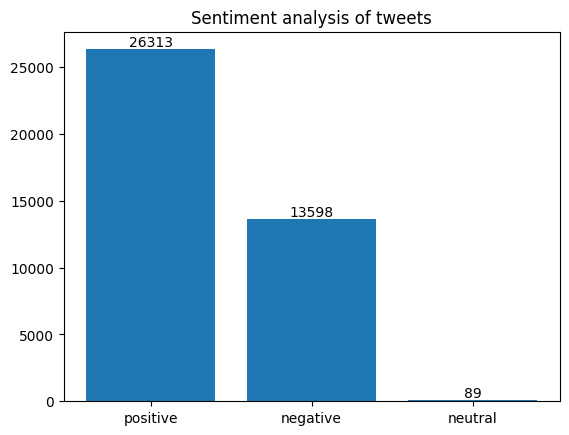

In [ ]:
# plot results
docs_max_pred = [max(sublist, key=lambda x: x['score']) for sublist in docs_predictions]
docs_prediction_count = countPredictions(docs_max_pred)
clean_text_df['sentiment'] = [pred['label'] for pred in docs_max_pred]

plotBarchart(docs_prediction_count, 'Sentiment analysis of tweets')


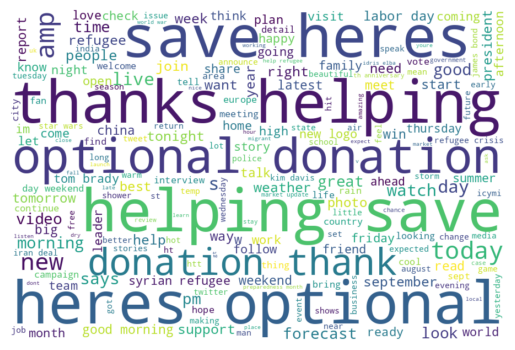

In [ ]:
# source: https://python-charts.com/ranking/wordcloud-matplotlib/?utm_content=cmp-true
# source: https://medium.com/@aditya.ce21/decoding-emotions-sentiment-analysis-with-distilbert-f7096da29274

positive_indices = [index for index, d in enumerate(docs_max_pred) if d['label'] == 'positive']
positive_docs = clean_text_df['clean_text'].iloc[positive_indices]

# word cloud of positive sentiment tweets
combined_docs = ' '.join(positive_docs.astype(str))
wc = WordCloud(width = 900, height = 600, background_color = "white")
wc.generate(combined_docs)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")


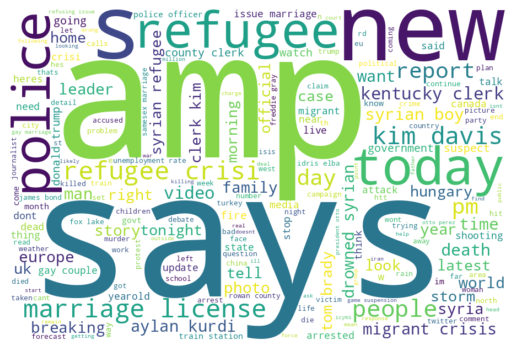

In [ ]:
negative_indices = [index for index, d in enumerate(docs_max_pred) if d['label'] == 'negative']
negative_docs = clean_text_df['clean_text'].iloc[negative_indices]

# word cloud of positive sentiment tweets
combined_docs = ' '.join(negative_docs.astype(str))
wc = WordCloud(width = 900, height = 600, background_color = "white")
wc.generate(combined_docs)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

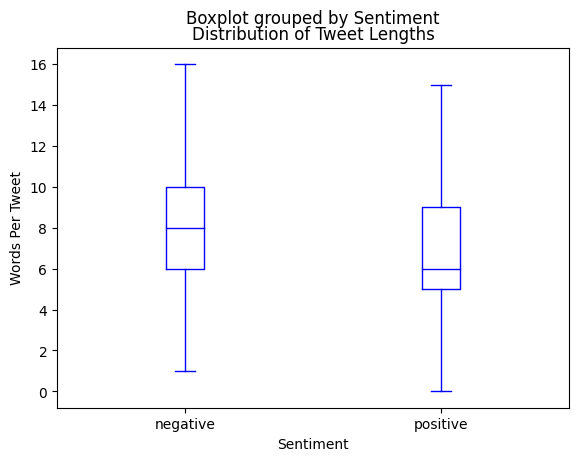

In [ ]:
# boxplot of the length of positive and negative tweets
docs_df = pd.DataFrame()
docs_df["positive"] = positive_docs.str.split().apply(len).reset_index(drop=True)
docs_df["negative"] = negative_docs.str.split().apply(len).reset_index(drop=True)
# Melt the DataFrame to have the lengths in a single column and an identifying column for positive and negative
df = docs_df.melt(var_name='Sentiment', value_name='Words Per Document')

df.boxplot("Words Per Document", by="Sentiment", grid=False, showfliers=False, color="blue")
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Sentiment')
plt.ylabel('Words Per Tweet')
plt.show()


## Sentiment analysis of queries

In [ ]:
# Get the predictions
query = clean_query_df['clean_query'].tolist()

# Get predictions
predictions = sentiment_pipeline(query)

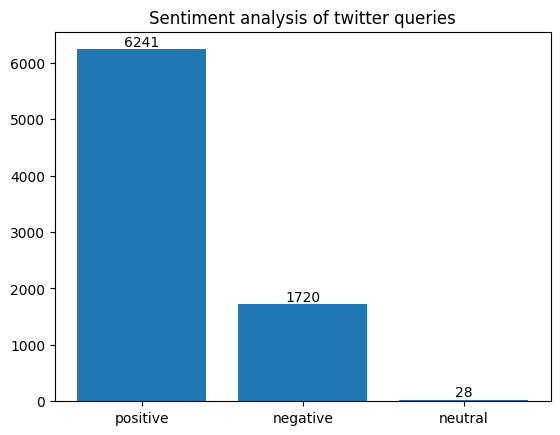

In [ ]:
# plot results
max_pred = [max(sublist, key=lambda x: x['score']) for sublist in predictions]
prediction_count = countPredictions(max_pred)
clean_query_df['sentiment'] = [pred['label'] for pred in max_pred]

plotBarchart(prediction_count, 'Sentiment analysis of twitter queries')

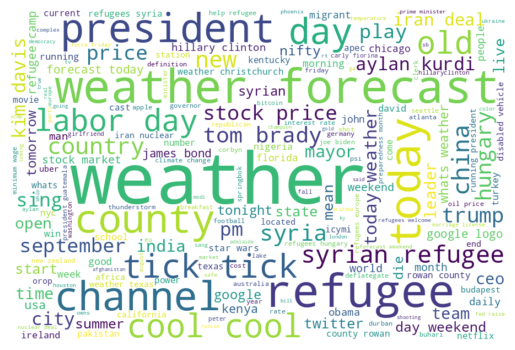

In [ ]:
positive_indices = [index for index, d in enumerate(max_pred) if d['label'] == 'positive']
positive_docs = clean_query_df['clean_query'].iloc[positive_indices]

# word cloud of positive sentiment tweets
combined_docs = ' '.join(positive_docs.astype(str))
wc = WordCloud(width = 900, height = 600, background_color = "white")
wc.generate(combined_docs)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

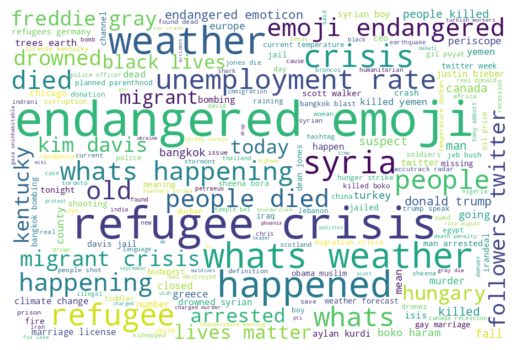

In [ ]:
negative_indices = [index for index, d in enumerate(max_pred) if d['label'] == 'negative']
negative_docs = clean_query_df['clean_query'].iloc[negative_indices]

# word cloud of positive sentiment tweets
combined_docs = ' '.join(negative_docs.astype(str))
wc = WordCloud(width = 900, height = 600, background_color = "white")
wc.generate(combined_docs)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

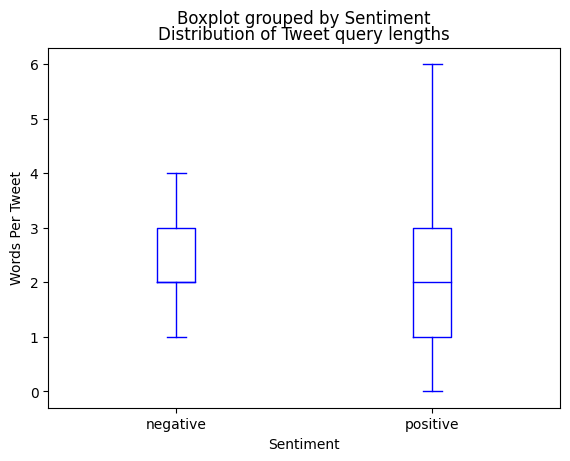

In [ ]:
# boxplot of the length of positive and negative tweets
docs_df = pd.DataFrame()
docs_df["positive"] = positive_docs.str.split().apply(len).reset_index(drop=True)
docs_df["negative"] = negative_docs.str.split().apply(len).reset_index(drop=True)
# Melt the DataFrame to have the lengths in a single column and an identifying column for positive and negative
df = docs_df.melt(var_name='Sentiment', value_name='Words Per Document')

df.boxplot("Words Per Document", by="Sentiment", grid=False, showfliers=False, color="blue")
plt.title('Distribution of Tweet query lengths')
plt.xlabel('Sentiment')
plt.ylabel('Words Per Tweet')
plt.show()


# Correlation between topics and sentiments

By correlating the dominant themes identified through BERTopic with the positive, negative, and neutral sentiments from our sentiment analysis, we aim to provide a better understanding of how certain topics may inherently carry emotional weight or how the sentiment could shape the discourse around these topics.

## Correlation in tweets

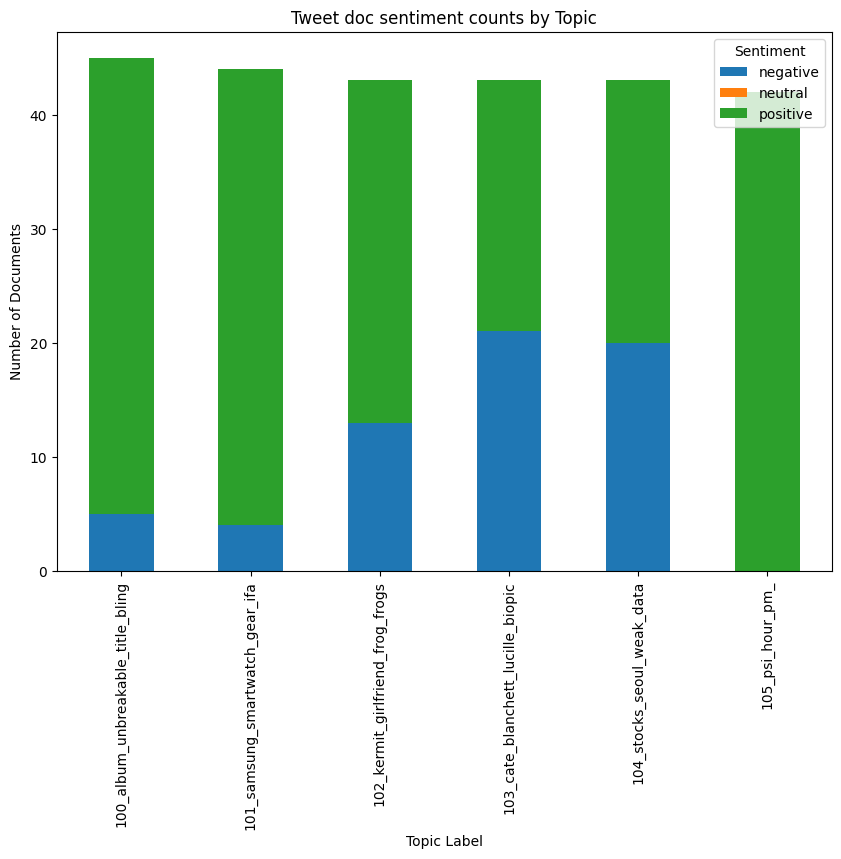

In [ ]:
# table with the number of sentiments per topic
topic_sentiment_counts = pd.crosstab(clean_text_df['topic_label'], clean_text_df['sentiment'])
topic_sentiment = topic_sentiment_counts.iloc[2:8]
topic_sentiment.plot(kind='bar', stacked=True, figsize=(10, 7))

# plot the graphic
plt.title('Tweet doc sentiment counts by Topic')
plt.xlabel('Topic Label')
plt.ylabel('Number of Documents')
plt.legend(title='Sentiment')
plt.show()

## Correlation in queries

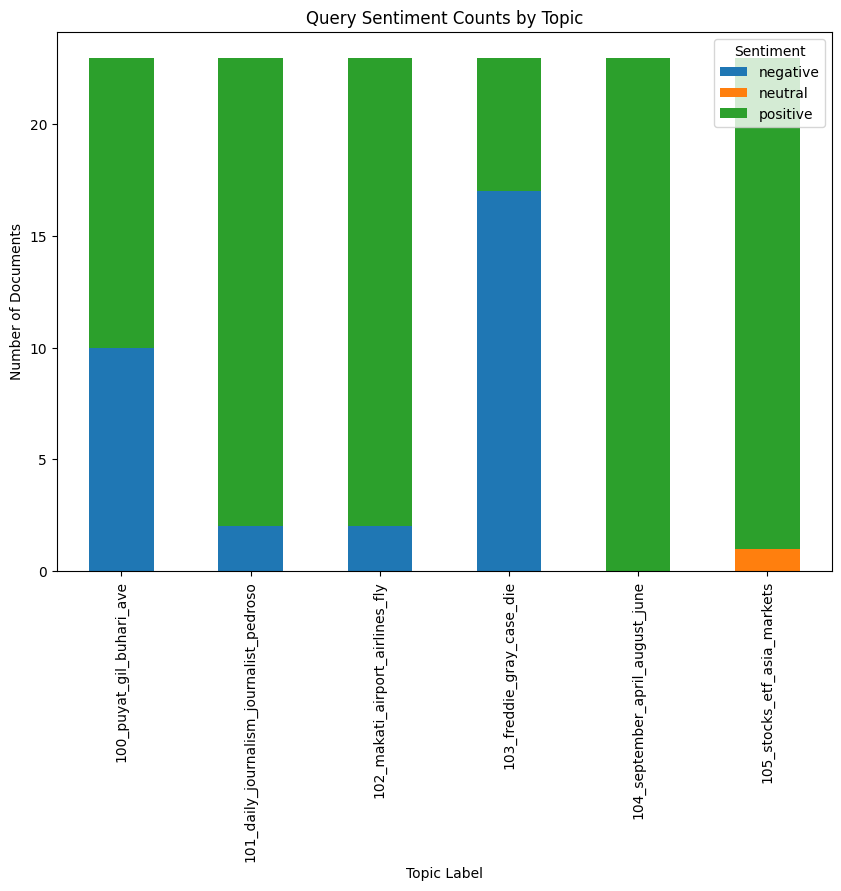

In [ ]:
# table with the number of sentiments per topic
topic_sentiment_counts = pd.crosstab(clean_query_df['topic_label'], clean_query_df['sentiment'])
topic_sentiment = topic_sentiment_counts.iloc[2:8]
topic_sentiment.plot(kind='bar', stacked=True, figsize=(10, 7))

# plot the graphic
plt.title('Query Sentiment Counts by Topic')
plt.xlabel('Topic Label')
plt.ylabel('Number of Documents')
plt.legend(title='Sentiment')
plt.show()